In [2]:
!pip install sentence-transformers umap-learn scikit-learn matplotlib seaborn

   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.8/212.5 MB 4.2 MB/s eta 0:00:51
   ---------------------------------------- 1.6/212.5 MB 4.0 MB/s eta 0:00:53
   ---------------------------------------- 2.1/212.5 MB 3.8 MB/s eta 0:00:55
    --------------------------------------- 3.1/212.5 MB 3.7 MB/s eta 0:00:58
    --------------------------------------- 3.9/212.5 MB 3.6 MB/s eta 0:00:58
    --------------------------------------- 5.0/212.5 MB 3.9 MB/s eta 0:00:54
   - -------------------------------------- 5.8/212.5 MB 3.9 MB/s eta 0:00:54
   - -------------------------------------- 6.3/212.5 MB 3.8 MB/s eta 0:00:55
   - -------------------------------------- 7.3/212.5 MB 3.8 MB/s eta 0:00:54
   - -------------------------------------- 8.1/212.5 MB 3.8 MB/s eta 0:00:54
   - -------------------------------------- 9.2/212.5 MB 3.9 MB/s eta 0:00:53
   - -------------------------------------- 10.2/212.5 MB 4.0 MB/s eta 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# ============================================
# 0. IMPORTS AND SETUP
# ============================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import umap.umap_ as umap

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

c:\Users\tered\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Paths
data_path = r"C:\Users\tered\Desktop\recommender_system\data\processed\books_titles_clean.csv"
output_dir = r"C:\Users\tered\Desktop\recommender_system\experiments\04_sbert_kmeans"

os.makedirs(output_dir, exist_ok=True)

In [5]:
# ============================================
# 1. LOAD DATA
# ============================================
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} book titles")
df.head()

Loaded 6810 book titles


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,ID
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,1
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,2
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,3
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,4
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,5


In [6]:
# ============================================
# 2. SBERT EMBEDDING
# ============================================
print("Loading SBERT model and encoding titles...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['title'].tolist(), show_progress_bar=True)
embeddings = np.array(embeddings)
print(f"Embeddings shape: {embeddings.shape}")

Loading SBERT model and encoding titles...


c:\Users\tered\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tered\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not insta

Embeddings shape: (6810, 384)


In [7]:
# ============================================
# 3. KMEANS CLUSTERING
# ============================================
# Select number of clusters (tune if needed)
k = 10
print(f"Clustering embeddings into {k} clusters...")
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)
df['cluster'] = cluster_labels

# Silhouette Score for all data and clusters
sil_score = silhouette_score(embeddings, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Clustering embeddings into 10 clusters...
Silhouette Score: 0.0132


In [8]:
# ============================================
# 4. FUNCTION TO GET TOP-N RECOMMENDATIONS BASED ON COSINE SIMILARITY
# ============================================
def get_top_n_recommendations(embeddings, index, n=10):
    """
    Given all embeddings and a target index,
    return indices of top-n most similar books excluding itself.
    """
    cosine_sim = cosine_similarity([embeddings[index]], embeddings)[0]
    sim_scores = list(enumerate(cosine_sim))
    # Exclude itself
    sim_scores = [x for x in sim_scores if x[0] != index]
    # Sort by similarity descending
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_n_indices = [i for i, score in sim_scores[:n]]
    top_n_scores = [score for i, score in sim_scores[:n]]
    return top_n_indices, top_n_scores

In [9]:
# ============================================
# 5. DIVERSITY METRIC (INTRA-LIST DIVERSITY)
# ============================================
def intra_list_diversity(embedding_subset):
    """
    Compute mean pairwise cosine distance (1 - cosine similarity) within a list of embeddings.
    Higher values = more diverse.
    """
    if len(embedding_subset) < 2:
        return 0  # Diversity undefined for single item
    cosine_sim_matrix = cosine_similarity(embedding_subset)
    cosine_dist_matrix = 1 - cosine_sim_matrix
    # Take lower triangle without diagonal
    tril_indices = np.tril_indices_from(cosine_dist_matrix, k=-1)
    mean_diversity = np.mean(cosine_dist_matrix[tril_indices])
    return mean_diversity

In [10]:
# ============================================
# 6. VISUALIZATION FUNCTION (t-SNE and UMAP)
# ============================================
def visualize_embeddings(embeddings, labels, output_dir):
    """
    Generate and save t-SNE and UMAP plots colored by cluster labels.
    """
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_proj = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=labels, palette='tab10', legend='full', s=15)
    plt.title("t-SNE Projection of Book Titles")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "tsne_projection.png"))
    plt.show()

    print("Running UMAP...")
    reducer = umap.UMAP(random_state=42)
    umap_proj = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=labels, palette='tab10', legend='full', s=15)
    plt.title("UMAP Projection of Book Titles")
    plt.xlabel("UMAP dim 1")
    plt.ylabel("UMAP dim 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "umap_projection.png"))
    plt.show()

In [ ]:
# ============================================
# 7. RUN RECOMMENDATION FOR TARGET INDEX AND COMPUTE METRICS
# ============================================
target_index = 2676
print(f"Getting top 10 recommendations for book index {target_index}...")
top_10_indices, top_10_scores = get_top_n_recommendations(embeddings, target_index, n=10)

top_10_titles = df.iloc[top_10_indices]['title'].tolist()
print("\nTop 10 recommended titles:")
for i, title in enumerate(top_10_titles, 1):
    print(f"{i}. {title}")

# Average cosine similarity of recommendations
mean_cos_sim = np.mean(top_10_scores)
print(f"\nAverage Cosine Similarity (Top 10): {mean_cos_sim:.4f}")

# Intra-list diversity for the recommended titles
top_10_embeddings = embeddings[top_10_indices]
ild_score = intra_list_diversity(top_10_embeddings)
print(f"Intra-list Diversity (Top 10): {ild_score:.4f}")


Getting top 10 recommendations for book index 2676...

Top 10 recommended titles:
1. Harry Potter and the Half-Blood Prince (Book 6)
2. Harry Potter and the Prisoner of Azkaban (Book 3)
3. Harry Potter and the Sorcerer's Stone (Book 1)
4. Harry Potter and the Chamber of Secrets (Book 2)
5. Harry Potter and the Goblet of Fire
6. Harry Potter and the Prisoner of Azkaban
7. Harry Potter and the Chamber of Secrets
8. The Harry Potter Collection
9. Harry Potter
10. Harry Potter and Philosophy

Average Cosine Similarity (Top 10): 0.6989
Intra-list Diversity (Top 10): 0.2933


In [15]:
# ============================================
# 7. RUN RECOMMENDATION FOR TARGET INDEX AND COMPUTE METRICS
# ============================================
target_index = 2710

selected_title = df.iloc[target_index]['title']
print(f"Finding recommendations for book index: {target_index}\n")
print(f"Selected book [{target_index}]: {selected_title}\n")

top_10_indices, top_10_scores = get_top_n_recommendations(embeddings, target_index, n=10)
print("Top 10 Recommendations based on SBERT + Cosine Similarity:\n")

for rank, (idx, score) in enumerate(zip(top_10_indices, top_10_scores), 1):
    title = df.iloc[idx]['title']
    print(f"{rank}. [{idx}] {title} (Similarity: {score:.4f})")

# Average cosine similarity of recommendations
mean_cos_sim = np.mean(top_10_scores)
print(f"\nAverage Cosine Similarity (Top 10): {mean_cos_sim:.4f}")

# Intra-list diversity for the recommended titles
top_10_embeddings = embeddings[top_10_indices]
ild_score = intra_list_diversity(top_10_embeddings)
print(f"Intra-list Diversity (Top 10): {ild_score:.4f}")


Finding recommendations for book index: 2710

Selected book [2710]: Harry Potter and the Prisoner of Azkaban (Book 3)

Top 10 Recommendations based on SBERT + Cosine Similarity:

1. [4525] Harry Potter and the Prisoner of Azkaban (Similarity: 0.8933)
2. [2676] Harry Potter and the Order of the Phoenix (Book 5) (Similarity: 0.7429)
3. [2661] Harry Potter and the Chamber of Secrets (Book 2) (Similarity: 0.7398)
4. [2698] Harry Potter and the Sorcerer's Stone (Book 1) (Similarity: 0.7309)
5. [2723] Harry Potter and the Half-Blood Prince (Book 6) (Similarity: 0.7149)
6. [2697] Harry Potter and the Chamber of Secrets (Similarity: 0.6969)
7. [2730] The Harry Potter Collection (Similarity: 0.6928)
8. [4508] Harry Potter and the Goblet of Fire (Similarity: 0.6901)
9. [5330] JK Rowling's Harry Potter Novels (Similarity: 0.6593)
10. [2712] Harry Potter (Similarity: 0.6582)

Average Cosine Similarity (Top 10): 0.7219
Intra-list Diversity (Top 10): 0.3024


Running t-SNE...


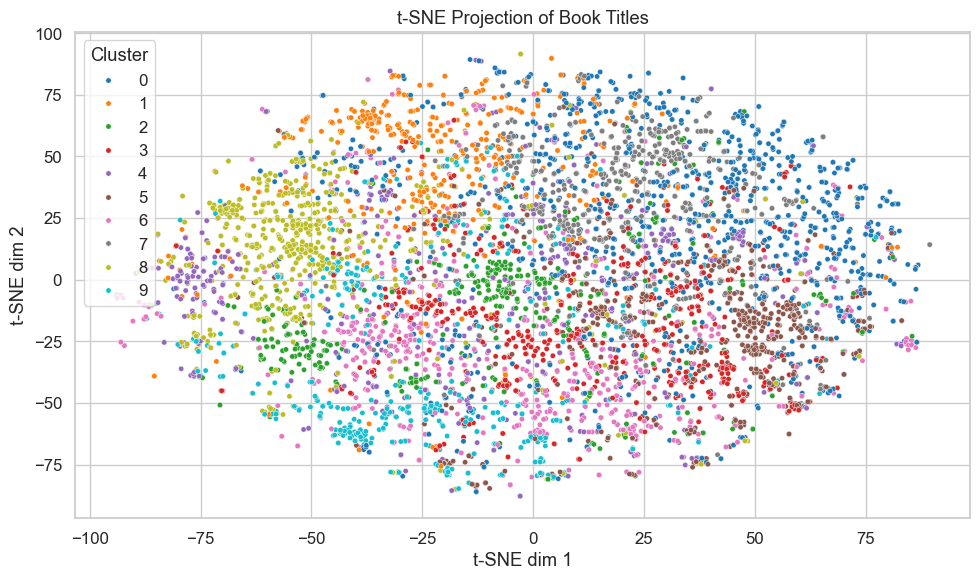

Running UMAP...


c:\Users\tered\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tered\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


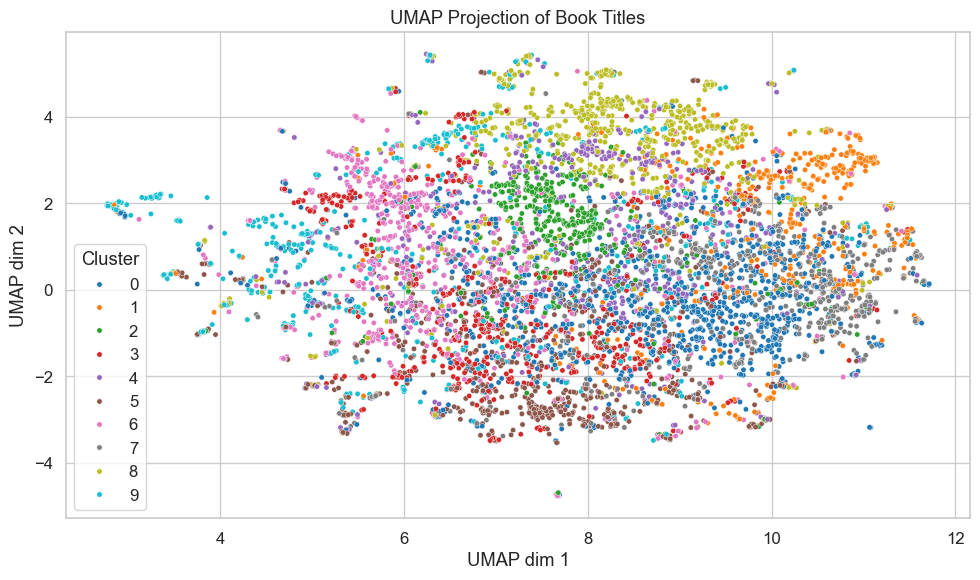

In [12]:
# ============================================
# 8. VISUALIZE EMBEDDINGS WITH CLUSTERS
# ============================================
visualize_embeddings(embeddings, df['cluster'], output_dir)


In [13]:
# ============================================
# 9. FINAL SUMMARY
# ============================================
print("\n===== FINAL METRICS SUMMARY =====")
print(f"Silhouette Score (all data clusters): {sil_score:.4f}")
print(f"Average Cosine Similarity (Top 10 recommendations): {mean_cos_sim:.4f}")
print(f"Intra-list Diversity (Top 10 recommendations): {ild_score:.4f}")
print("FID: Not Applicable for text embeddings")


===== FINAL METRICS SUMMARY =====
Silhouette Score (all data clusters): 0.0132
Average Cosine Similarity (Top 10 recommendations): 0.6989
Intra-list Diversity (Top 10 recommendations): 0.2933
FID: Not Applicable for text embeddings
